In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

In [24]:
train_image_dir="/Users/withmocha/Desktop/DATA/Capston Design(2024)/deep voice data/image/melspectogram/train/"
test_image_dir="/Users/withmocha/Desktop/DATA/Capston Design(2024)/deep voice data/image/melspectogram/test/"

In [25]:
train_datagen = ImageDataGenerator( 
    rescale=1./299,
    preprocessing_function=preprocess_input,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.3,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    vertical_flip=True,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(
    rescale=1./299,
    preprocessing_function=preprocess_input,
    
)



In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import preprocess_input  
def get_dataset(directory, batch_size):
    dataset = image_dataset_from_directory(
        directory,
        shuffle=True,
        batch_size=batch_size,
        image_size=(299, 299),
        label_mode='binary',
    )
    class_names = dataset.class_names  
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))
    return dataset, class_names  


In [27]:
train_dataset, train_class_names = get_dataset(train_image_dir, 20)
val_dataset, val_class_names = get_dataset(test_image_dir, 20)

Found 2684 files belonging to 2 classes.
Found 1088 files belonging to 2 classes.


In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


In [31]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(15,15))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[int(label_batch[n])])
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/gb/hslcbzfs0bvcnj3zxtfrxt_r0000gn/T/ipykernel_20129/2770834567.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(label_batch[n])])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

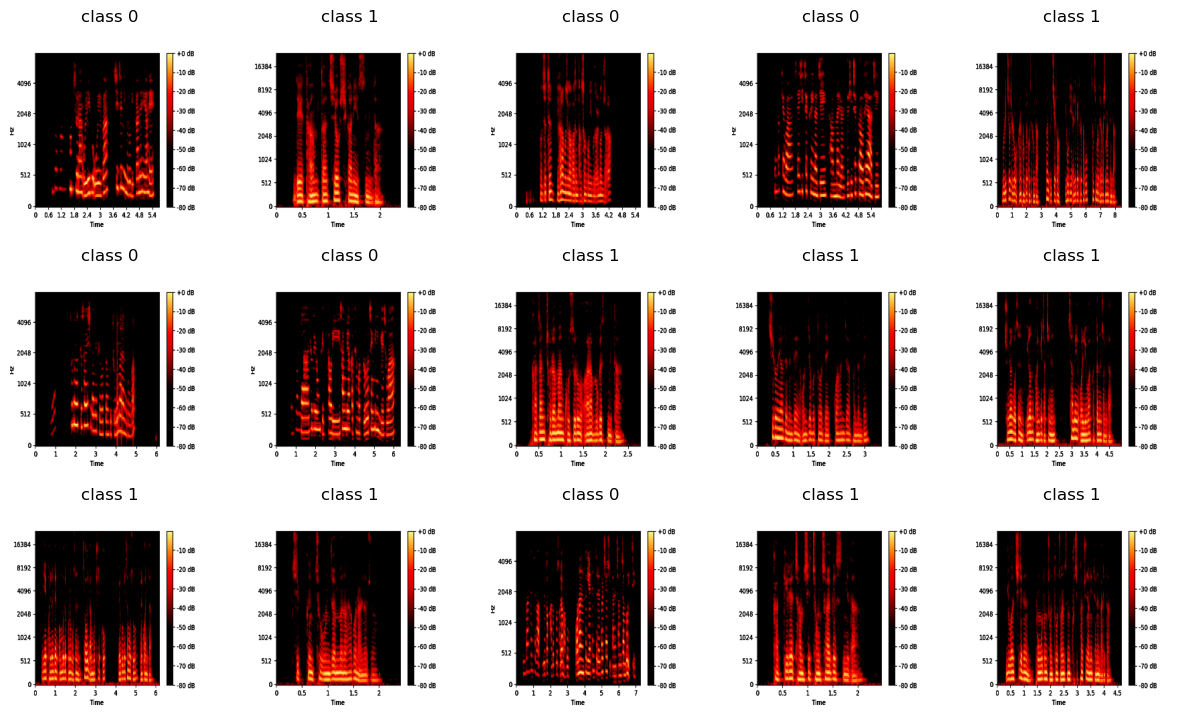

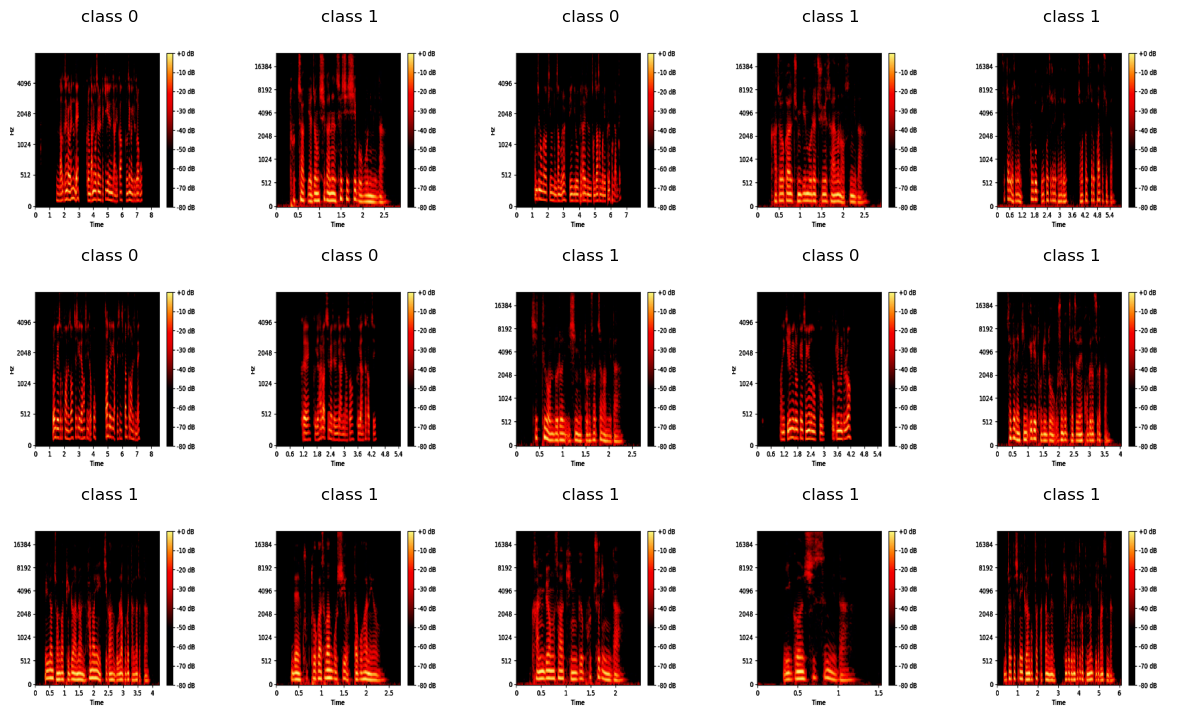

In [32]:

train_image_batch, train_label_batch = next(iter(train_dataset))
show_batch(train_image_batch.numpy(), train_label_batch.numpy(), train_class_names)


val_image_batch, val_label_batch = next(iter(val_dataset))
show_batch(val_image_batch.numpy(), val_label_batch.numpy(), val_class_names)

In [33]:
base_model = InceptionV3(weights=None, include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)




In [34]:
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [35]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 2:
        return float(lr) 
    else:
        return float(lr * tf.math.exp(-0.1))  

lr_scheduler = LearningRateScheduler(scheduler)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


In [37]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, reduce_lr],
    shuffle=True
)


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 630s 5s/step - accuracy: 0.8962 - loss: 1.0765 - val_accuracy: 0.5175 - val_loss: 2.1964 - learning_rate: 0.0020
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 613s 5s/step - accuracy: 0.9852 - loss: 0.0689 - val_accuracy: 0.5175 - val_loss: 1.7158 - learning_rate: 0.0020
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 669s 5s/step - accuracy: 0.9983 - loss: 0.0236 - val_accuracy: 0.9982 - val_loss: 0.0218 - learning_rate: 0.0018
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 656s 5s/step - accuracy: 0.9999 - loss: 0.0097 - val_accuracy: 0.8529 - val_loss: 0.2931 - learning_rate: 0.0016
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 634s 5s/step - accuracy: 0.9953 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.0103 - learning_rate: 0.0015
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0013
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 577s 4s/step - accuracy: 1.0000 - l

In [49]:
model.save('deep voice image detection model.keras')

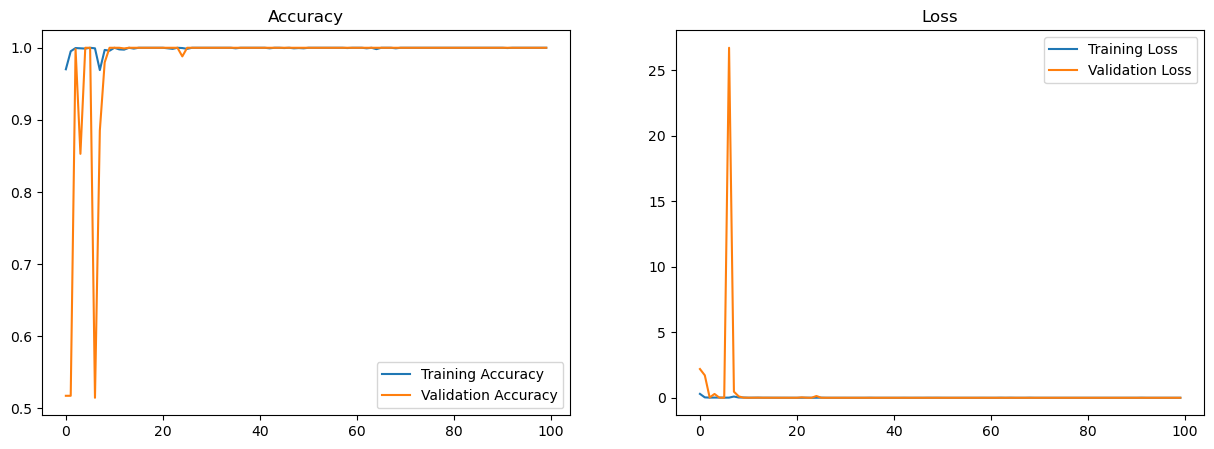

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [40]:
import numpy as np
from sklearn.metrics import roc_curve, f1_score, accuracy_score


val_predictions = model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)


fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)


J = tpr - fpr
idx = np.argmax(J)
best_thresh_youden = thresholds[idx]
print(f"Youden의 J지수를 최대화하는 임계값: {best_thresh_youden}")


f1_scores = [f1_score(val_labels, val_predictions > t) for t in thresholds]
best_thresh_f1 = thresholds[np.argmax(f1_scores)]
print(f"F1 score를 최대화하는 임계값: {best_thresh_f1}")


optimized_pred_youden = (val_predictions > best_thresh_youden).astype(int)
optimized_pred_f1 = (val_predictions > best_thresh_f1).astype(int)


accuracy_youden = accuracy_score(val_labels, optimized_pred_youden)
accuracy_f1 = accuracy_score(val_labels, optimized_pred_f1)

print(f"Youden의 J지수를 사용한 최적의 임계값에 대한 정확도: {accuracy_youden}")
print(f"F1 score를 사용한 최적의 임계값에 대한 정확도: {accuracy_f1}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step


2024-05-17 16:49:21.552080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Youden의 J지수를 최대화하는 임계값: 0.9999896883964539
F1 score를 최대화하는 임계값: 3.192688609487959e-06
Youden의 J지수를 사용한 최적의 임계값에 대한 정확도: 0.5303308823529411
F1 score를 사용한 최적의 임계값에 대한 정확도: 0.4963235294117647


In [41]:
import numpy as np

class_labels = val_class_names

true_classes = []
for _, labels in val_dataset.take(-1): 
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)


predictions = model.predict(val_dataset)
predicted_classes = np.where(predictions > best_thresh_f1, 1, 0)



2024-05-17 16:49:23.084269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


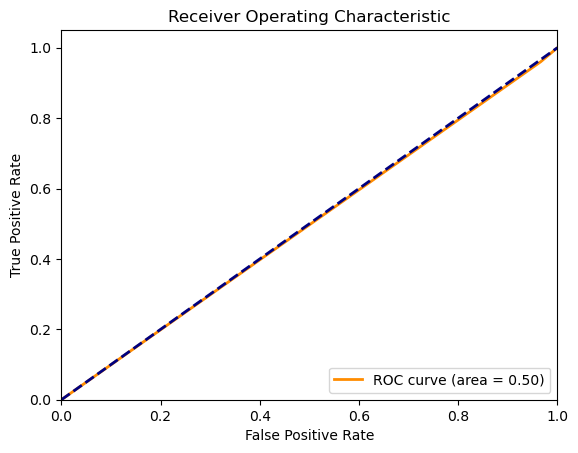

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import numpy as np


fpr, tpr, _ = roc_curve(true_classes, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

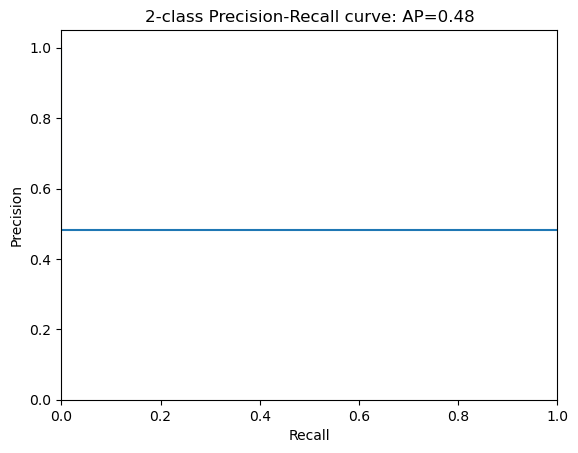

In [43]:
precision, recall, _ = precision_recall_curve(true_classes, predicted_classes)
average_precision = average_precision_score(true_classes, predicted_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

Confusion Matrix:


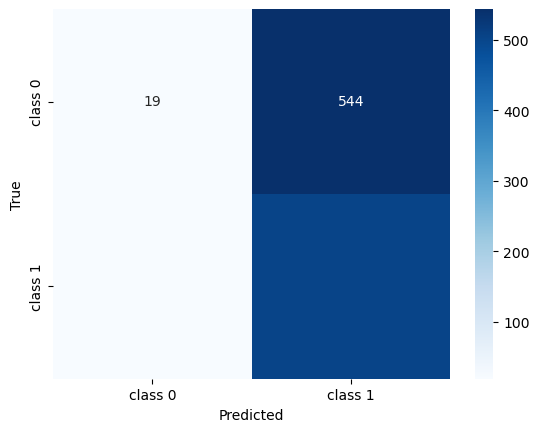

Classification Report:
              precision    recall  f1-score   support

     class 0       0.47      0.03      0.06       563
     class 1       0.48      0.96      0.64       525

    accuracy                           0.48      1088
   macro avg       0.48      0.50      0.35      1088
weighted avg       0.48      0.48      0.34      1088



In [44]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [45]:
with open("V3 confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(true_classes, predicted_classes), file=text_file)

In [46]:
with open("V3 classification report output.txt", "w") as text_file:
    print(classification_report(true_classes, predicted_classes,digits=4), file=text_file)